In [3]:
# 必要なライブラリのインストール
!pip install librosa matplotlib

import librosa # f0を読み込むためのライブラリ
import numpy as np # 配列操作用。機械学習においては[n, 1]という配列を用いるため、npを用いて配列操作するのが利にかなっている
import matplotlib.pyplot as plt # データ可視化ライブラリの一つ。著感的なコマンドでグラフ（折れ線、散布図、棒グラフ等）を作成可能
from IPython.display import Audio, display # UIを綺麗にしてdisplayするためのライブラリ。audioを出力する際に用いる
from google.colab import output # よくわからないライブラリ
from base64 import b64decode # Base64形式で保存されたデータを元のバイナリ形式に戻すためのもの

# 録音用のJavascriptコード（Colab特有のおまじない）
RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time * 1000)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=5):
  print("🔴 録音開始... (5秒間歌ってください)")
  output.eval_js(RECORD)
  text = output.eval_js('record(%d)' % (sec))
  name = 'my_voice.wav'
  with open(name, 'wb') as f:
    f.write(b64decode(text.split(',')[1]))
  print("✅ 録音完了: my_voice.wav")
  return name

# 実行して録音する
filename = record(sec=5)

# 録音した音を読み込む
# y: 音声データ, sr: サンプリングレート
y, sr = librosa.load(filename, sr=16000)

# 確認のため再生
print("元の音声:")
display(Audio(y, rate=sr))

🔴 録音開始... (5秒間歌ってください)
✅ 録音完了: my_voice.wav


/tmp/ipython-input-1189112722.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename, sr=16000)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


元の音声:


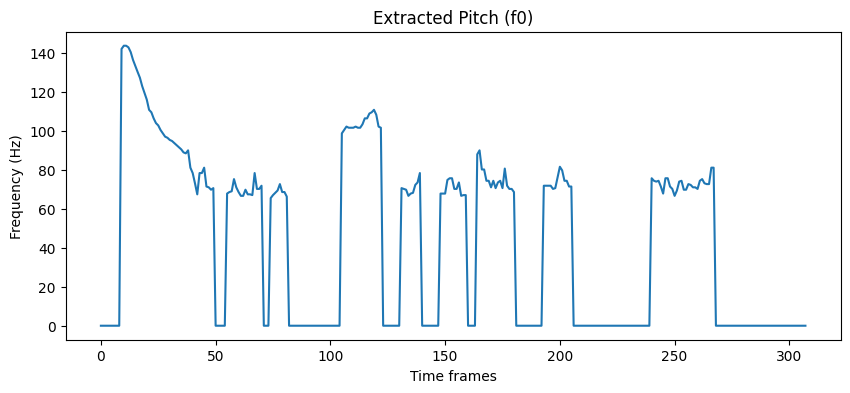

f0_tensor shape: torch.Size([308, 1])


In [4]:
import torch # 機械学習用ライブラリ

# 1. librosaを使ってピッチ抽出 (PYINアルゴリズム)
# f0: 時系列の周波数データ
# voiced_flag: 「声が出ているか(True)」「無音か(False)」のフラグ
f0_numpy, voiced_flag, voiced_probs = librosa.pyin(
    y,
    fmin=librosa.note_to_hz('C2'), # 最低音
    fmax=librosa.note_to_hz('C7'), # 最高音
    sr=sr,
    frame_length=1024
)

# 2. 扱いやすいように前処理
# 無音部分(NaN)を 0.0 に置き換える
f0_numpy = np.nan_to_num(f0_numpy)

# 3. PyTorchのTensorに変換 + 「形」を整える
# ここで例の unsqueeze(-1) が登場します！
# 時間軸方向にデータが並ぶように [T, 1] の形にします。
f0_tensor = torch.from_numpy(f0_numpy).float().unsqueeze(-1)

# グラフで見てみる
plt.figure(figsize=(10, 4))
plt.plot(f0_numpy)
plt.title("Extracted Pitch (f0)")
plt.xlabel("Time frames")
plt.ylabel("Frequency (Hz)")
plt.show()

print(f"f0_tensor shape: {f0_tensor.shape}")

In [8]:
class MultiScaleSpectralLoss(nn.Module):
    def __init__(self, fft_sizes=[2048, 1024, 512, 256, 128, 64]):
        super().__init__()
        self.fft_sizes = fft_sizes

    def forward(self, target_audio, pred_audio):
        loss = 0.0

        for n_fft in self.fft_sizes:
            hop = n_fft // 4

            # STFT計算
            target_S = torch.stft(
                target_audio, n_fft, hop_length=hop,
                window=torch.hann_window(n_fft).to(target_audio.device),
                return_complex=True
            ).abs()

            pred_S = torch.stft(
                pred_audio, n_fft, hop_length=hop,
                window=torch.hann_window(n_fft).to(pred_audio.device),
                return_complex=True
            ).abs()

            # 【修正点】サイズが合わない場合、短い方に合わせて切り詰める
            if target_S.shape[-1] != pred_S.shape[-1]:
                min_len = min(target_S.shape[-1], pred_S.shape[-1])
                target_S = target_S[..., :min_len]
                pred_S = pred_S[..., :min_len]

            # ロス加算
            loss += F.l1_loss(target_S, pred_S)
            loss += F.l1_loss(torch.log(target_S + 1e-7), torch.log(pred_S + 1e-7))

        return loss

🚀 爆速学習開始！
Epoch 50 | Loss: 21.2360
Epoch 100 | Loss: 19.2655
Epoch 150 | Loss: 18.0581
Epoch 200 | Loss: 17.0606
Epoch 250 | Loss: 16.4085
Epoch 300 | Loss: 15.9759
Epoch 350 | Loss: 15.2822
Epoch 400 | Loss: 22.3351
Epoch 450 | Loss: 19.0863
Epoch 500 | Loss: 17.3460


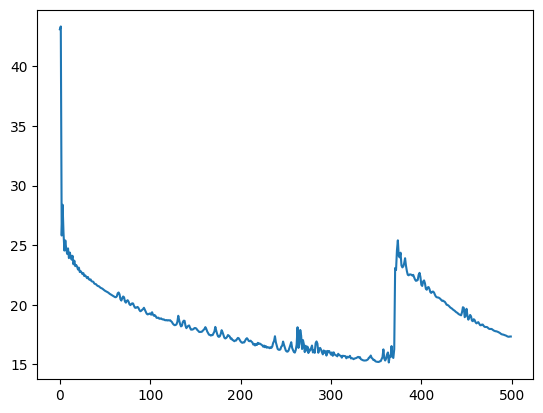

生成音声を再生:


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# cuDNNは有効に戻しておきます（速いので）
torch.backends.cudnn.enabled = True

# --- 1. 軽量モデル定義 (GRU廃止 -> Conv1d/Linear採用) ---
class DDSP_MLP(nn.Module):
    def __init__(self, n_harmonics=60, n_hidden=256):
        super().__init__()
        self.n_harmonics = n_harmonics
        self.sr = 16000

        # Encoder (GRUの代わりに1次元畳み込みを使う)
        # Conv1dは「前後少しの文脈」を見るだけなので高速でエラーが出ない
        # Input: 2 (f0, loudness) -> Output: 16 (z)
        self.z_encoder = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 16, kernel_size=3, padding=1),
        )

        # Decoder (GRUの代わりに全結合層を使う)
        # Input: 18 (f0+loudness+z) -> Output: n_harmonics
        self.decoder = nn.Sequential(
            nn.Linear(18, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_harmonics + 1)
        )

    def forward(self, f0, loudness):
        # f0, loudness: [Batch, Time, 1]

        # --- Encoder (Conv1d用に [B, Ch, T] に入れ替え) ---
        x = torch.cat([f0, loudness], dim=-1) # [B, T, 2]
        x = x.permute(0, 2, 1)                # [B, 2, T]

        z = self.z_encoder(x)                 # [B, 16, T]
        z = z.permute(0, 2, 1)                # [B, T, 16] (元に戻す)

        # --- Decoder (Linear) ---
        decoder_input = torch.cat([f0, loudness, z], dim=-1) # [B, T, 18]
        controls = self.decoder(decoder_input)

        # 倍音制御パラメータ
        controls = 2.0 * torch.sigmoid(controls) ** 2.3 + 1e-7

        harmonic_dist = F.softmax(controls[:, :, :self.n_harmonics], dim=-1)
        global_amp = controls[:, :, self.n_harmonics:]
        harmonic_amplitudes = harmonic_dist * global_amp

        # --- Synthesizer ---
        audio = self.harmonic_synthesis(f0, harmonic_amplitudes)
        return audio

    def harmonic_synthesis(self, f0, amplitudes):
        # (ここは変更なし)
        batch_size, n_frames, _ = f0.shape
        harm_ratios = torch.arange(1, self.n_harmonics + 1).to(f0.device)
        harm_frequencies = f0 * harm_ratios

        nyquist = self.sr / 2
        mask = (harm_frequencies < nyquist).float()
        amplitudes = amplitudes * mask

        phase_increment = 2 * np.pi * harm_frequencies / self.sr
        phases = torch.cumsum(phase_increment, dim=1)

        # ここでランダム位相を加えるとユニゾン感がでますが、まずは学習のためゼロで
        audio = torch.sum(torch.sin(phases) * amplitudes, dim=-1)
        return audio

# --- 2. データの準備 ---
# --- 1. データの準備 ---
# さっき作った f0_tensor を使います (形状: [T, 1])
# 音声データ y も Tensorにします
y_tensor = torch.from_numpy(y).float()

# バッチ次元を追加 [1, T, 1] / [1, T]
train_f0 = f0_tensor.unsqueeze(0).to("cuda") # GPUへ
train_audio = y_tensor.unsqueeze(0).to("cuda") # GPUへ

# Loudness再計算
S = torch.stft(train_audio.squeeze(0), n_fft=2048, hop_length=64, window=torch.hann_window(2048).to("cuda"), return_complex=True)
train_loudness = 10.0 * torch.log10(torch.maximum(S.abs()**2, torch.tensor(1e-5).to("cuda")).sum(dim=0)).view(1, -1, 1)

# interpolate
# 時間の長さを合わせる（interpolate）
target_len = train_audio.shape[1]
train_f0 = F.interpolate(train_f0.transpose(1, 2), size=target_len, mode='linear').transpose(1, 2)
train_loudness = F.interpolate(train_loudness.transpose(1, 2), size=target_len, mode='linear').transpose(1, 2)

# --- 3. 学習実行 ---
model = DDSP_MLP(n_harmonics=100, n_hidden=512).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = MultiScaleSpectralLoss().to("cuda")

print("🚀 爆速学習開始！")
losses = []

for epoch in range(500): # 500回
    model.train()
    optimizer.zero_grad()

    pred_audio = model(train_f0, train_loudness)

    loss = criterion(train_audio, pred_audio)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}", flush=True) # flush=Trueで即座に表示

plt.plot(losses)
plt.show()

# --- 4. 結果確認 ---
model.eval()
with torch.no_grad():
    print("生成音声を再生:")
    recon_audio = model(train_f0, train_loudness)
    display(Audio(recon_audio.cpu().squeeze().numpy(), rate=16000))

In [10]:
# --- 学習済みモデルを使ったユニゾン生成 ---

# 1. 設定
n_clones = 4          # 何人のクローンを作るか
pitch_drift_amt = 3.0 # ピッチの揺らぎ幅 (Hz)
time_drift_ms = 30    # タイミングのズレ幅 (ms)

clones = []
model.eval() # 評価モード（学習ストップ）

print(f"🎤 {n_clones}人のAIクローンによる合唱を生成中...")

with torch.no_grad():
    for i in range(n_clones):
        # --- A. ピッチの揺らぎを作る (Smooth Noise) ---
        # さっきの手法と同じですが、今回はこれをAIへの入力に使います
        raw_noise = torch.randn_like(train_f0)

        # 移動平均で滑らかにする（カーネルサイズ大きめ＝ゆっくりした揺らぎ）
        smooth_noise = F.avg_pool1d(
            raw_noise.permute(0, 2, 1),
            kernel_size=3001, stride=1, padding=1500
        ).permute(0, 2, 1)

        # 揺らぎを適用
        f0_shifted = train_f0 + (smooth_noise * pitch_drift_amt)

        # --- B. AIによる音声生成 (ここが進化ポイント！) ---
        # ずらしたピッチ(f0) と 元の音量(loudness) をAIに入力します。
        # AIは「もしこのピッチで歌ったら、倍音はどうなるか？」を考えて波形を作ります。
        clone_audio = model(f0_shifted, train_loudness)

        # --- C. タイミングのズレ (Time Shift) ---
        # ランダムに時間をずらす
        shift_samples = int((np.random.rand() - 0.5) * 2 * time_drift_ms * (16000 / 1000))
        clone_audio = torch.roll(clone_audio, shifts=shift_samples, dims=1)

        clones.append(clone_audio)
        print(f"Clone {i+1}: Generated.")

# --- D. ミックス ---
# 積み重ねて平均を取る
ensemble = torch.stack(clones, dim=0)
unison_audio = torch.mean(ensemble, dim=0)

# --- E. 聴き比べ ---
print("\nORIGINAL (あなたの元の声):")
display(Audio(train_audio.cpu().squeeze().numpy(), rate=16000))

print(f"\nAI UNISON (Pitch drift: ±{pitch_drift_amt}Hz):")
display(Audio(unison_audio.cpu().squeeze().numpy(), rate=16000))

🎤 4人のAIクローンによる合唱を生成中...
Clone 1: Generated.
Clone 2: Generated.
Clone 3: Generated.
Clone 4: Generated.

ORIGINAL (あなたの元の声):



AI UNISON (Pitch drift: ±3.0Hz):
